샘플 수: 56, 길이 범위: 8.4 ~ 44.0 cm, 무게 범위: 5.9 ~ 1100.0 g
degree=1 -> CV_RMSE=91.766
degree=2 -> CV_RMSE=58.323
degree=3 -> CV_RMSE=57.532
degree=4 -> CV_RMSE=54.905
degree=5 -> CV_RMSE=58.020
✅ 최적 차수(degree) = 4
[Final Poly(deg=4)] RMSE=45.048 | R^2=0.983


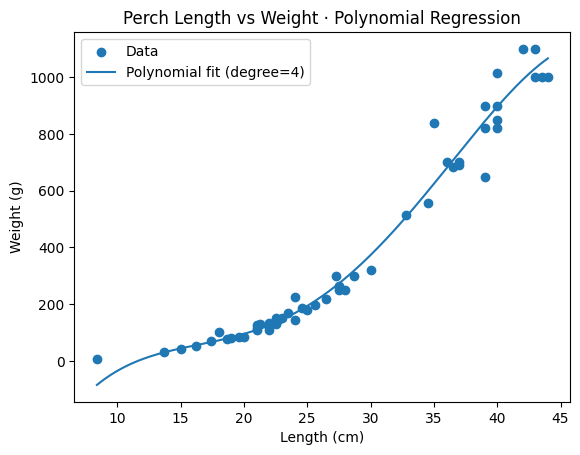

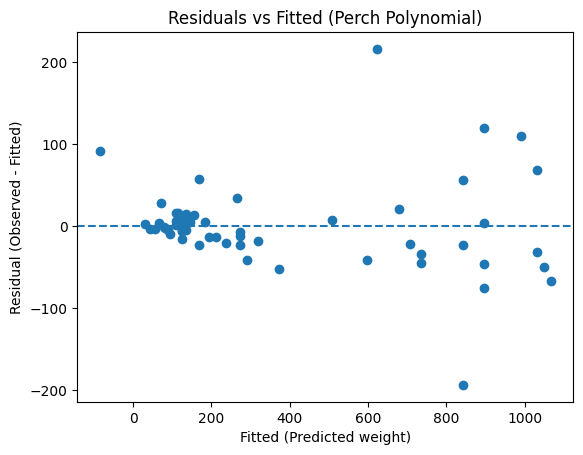

잔차 평균: 0.049973

[모델 식]
Weight ≈ -792.431812 + 149.711385*Length + -10.102761*Length^2 + 0.298152*Length^3 + -0.002819*Length^4

[Log-Linear] RMSE(log-space)=0.1339 | R^2=0.9903
추정 LWR 형태: Weight ≈ 0.006841 * Length^3.189466


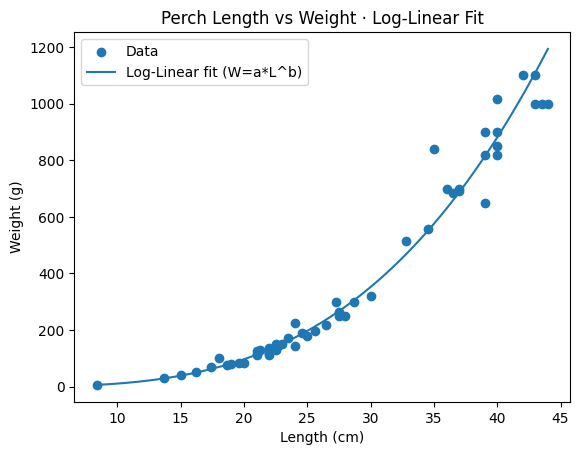

In [4]:
# ============================================================
# Perch(농어) 길이-무게 데이터 · 다항회귀 전체 코드 (완성본)
# - 주어진 배열만 사용
# - 차수 선택: KFold CV(RMSE 최소)
# - 최종 학습/평가/시각화/식 출력
# 규칙: matplotlib만 사용, 플롯은 한 번에 하나씩, 색상 지정 안 함
# ============================================================

import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, KFold

# -------------------------------
# 0) 데이터 (질문에서 제공)
# -------------------------------
perch_length = np.array([
    8.4, 13.7, 15.0, 16.2, 17.4, 18.0, 18.7, 19.0, 19.6, 20.0, 21.0,
    21.0, 21.0, 21.3, 22.0, 22.0, 22.0, 22.0, 22.0, 22.5, 22.5, 22.7,
    23.0, 23.5, 24.0, 24.0, 24.6, 25.0, 25.6, 26.5, 27.3, 27.5, 27.5,
    27.5, 28.0, 28.7, 30.0, 32.8, 34.5, 35.0, 36.5, 36.0, 37.0, 37.0,
    39.0, 39.0, 39.0, 40.0, 40.0, 40.0, 40.0, 42.0, 43.0, 43.0, 43.5,
    44.0
])
perch_weight = np.array([
    5.9, 32.0, 40.0, 51.5, 70.0, 100.0, 78.0, 80.0, 85.0, 85.0, 110.0,
    115.0, 125.0, 130.0, 120.0, 120.0, 130.0, 135.0, 110.0, 130.0,
    150.0, 145.0, 150.0, 170.0, 225.0, 145.0, 188.0, 180.0, 197.0,
    218.0, 300.0, 260.0, 265.0, 250.0, 250.0, 300.0, 320.0, 514.0,
    556.0, 840.0, 685.0, 700.0, 700.0, 690.0, 900.0, 650.0, 820.0,
    850.0, 900.0, 1015.0, 820.0, 1100.0, 1000.0, 1100.0, 1000.0,
    1000.0
])

X = perch_length.reshape(-1, 1)
y = perch_weight.astype(float)

print(f"샘플 수: {len(y)}, 길이 범위: {X.min():.1f} ~ {X.max():.1f} cm, 무게 범위: {y.min():.1f} ~ {y.max():.1f} g")

# -------------------------------
# 1) 홀드아웃 분할
# -------------------------------
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42)

# -------------------------------
# 2) 차수 선택: KFold CV(RMSE)
# -------------------------------
degrees = [1, 2, 3, 4, 5]
cv = KFold(n_splits=5, shuffle=True, random_state=42)

def cv_rmse_degree(deg):
    rmses = []
    for tr_idx, va_idx in cv.split(X_tr):
        X_tr_i, X_va_i = X_tr[tr_idx], X_tr[va_idx]
        y_tr_i, y_va_i = y_tr[tr_idx], y_tr[va_idx]
        pipe = Pipeline([
            ("poly", PolynomialFeatures(degree=deg, include_bias=False)),
            ("lin", LinearRegression())
        ])
        pipe.fit(X_tr_i, y_tr_i)
        pred = pipe.predict(X_va_i)
        rmses.append(np.sqrt(mean_squared_error(y_va_i, pred)))
    return float(np.mean(rmses))

deg_scores = [(d, cv_rmse_degree(d)) for d in degrees]
for d, s in deg_scores:
    print(f"degree={d} -> CV_RMSE={s:.3f}")

best_deg = min(deg_scores, key=lambda x: x[1])[0]
print(f"최적 차수(degree) = {best_deg}")

# -------------------------------
# 3) 최종 학습 & 홀드아웃 성능
# -------------------------------
final_model = Pipeline([
    ("poly", PolynomialFeatures(degree=best_deg, include_bias=False)),
    ("lin", LinearRegression())
])
final_model.fit(X_tr, y_tr)

pred_te = final_model.predict(X_te)
rmse = np.sqrt(mean_squared_error(y_te, pred_te))
r2   = r2_score(y_te, pred_te)
print(f"[Final Poly(deg={best_deg})] RMSE={rmse:.3f} | R^2={r2:.3f}")

# -------------------------------
# 4) 시각화 (산점 + 예측 곡선)
# -------------------------------
x_grid = np.linspace(X.min(), X.max(), 400).reshape(-1, 1)
y_grid = final_model.predict(x_grid)

plt.figure()
plt.scatter(X, y, label="Data")
plt.plot(x_grid, y_grid, label=f"Polynomial fit (degree={best_deg})")
plt.title("Perch Length vs Weight · Polynomial Regression")
plt.xlabel("Length (cm)")
plt.ylabel("Weight (g)")
plt.legend()
plt.show()

# -------------------------------
# 5) 잔차 진단 (예측 vs 잔차)
# -------------------------------
yhat_all = final_model.predict(X)
resid_all = y - yhat_all

plt.figure()
plt.scatter(yhat_all, resid_all)
plt.axhline(0, linestyle="--")
plt.title("Residuals vs Fitted (Perch Polynomial)")
plt.xlabel("Fitted (Predicted weight)")
plt.ylabel("Residual (Observed - Fitted)")
plt.show()
print(f"잔차 평균: {resid_all.mean():.6f}")

# -------------------------------
# 6) 모델 식(계수) 출력
# -------------------------------
poly = final_model.named_steps["poly"]
lin  = final_model.named_steps["lin"]
feat_names = poly.get_feature_names_out(["Length"])
coef = lin.coef_
intercept = lin.intercept_
formula = " + ".join([f"{c:.6f}*{n}" for c, n in zip(coef, feat_names)])
print("\n[모델 식]")
print(f"Weight ≈ {intercept:.6f} + {formula}")

# -------------------------------
# 7) (선택) 로그-선형 비교 (길이-무게 관계가 멱법칙에 가깝다면 종종 향상)
# -------------------------------
do_log_model = True
if do_log_model:
    Xl = np.log(X)
    yl = np.log(y)
    Xl_tr, Xl_te, yl_tr, yl_te = train_test_split(Xl, yl, test_size=0.2, random_state=42)
    lr_log = LinearRegression().fit(Xl_tr, yl_tr)
    yl_pred = lr_log.predict(Xl_te)
    rmse_l = np.sqrt(mean_squared_error(yl_te, yl_pred))
    r2_l   = r2_score(yl_te, yl_pred)
    print(f"\n[Log-Linear] RMSE(log-space)={rmse_l:.4f} | R^2={r2_l:.4f}")
    # y = exp(b0) * Length^(b1)
    a = np.exp(lr_log.intercept_)
    b = lr_log.coef_[0]
    print(f"추정 LWR 형태: Weight ≈ {a:.6f} * Length^{b:.6f}")

    # 시각화: 원공간에서 곡선 그리기
    Lg = np.linspace(X.min(), X.max(), 400).reshape(-1, 1)
    Wg = a * (Lg ** b)
    plt.figure()
    plt.scatter(X, y, label="Data")
    plt.plot(Lg, Wg, label="Log-Linear fit (W=a*L^b)")
    plt.title("Perch Length vs Weight · Log-Linear Fit")
    plt.xlabel("Length (cm)")
    plt.ylabel("Weight (g)")
    plt.legend()
    plt.show()
